In [1]:
# Data manipulation and analysis
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations and array manipulation
import scipy as sp  # For scientific and technical computing
from scipy.special import expit  # For the sigmoid function, the choice function
from scipy import stats  # To draw from a truncated normal disterbution

# Probabilistic programming and Bayesian statistical modeling
import pymc as pm  
import arviz as az  

# Data visualization
import matplotlib.pyplot as plt 
import seaborn as sns  

# Suppressing warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

import logging
logger = logging.getLogger("pymc")
logger.propagate = False
logger.setLevel(logging.ERROR)

In [2]:
# Loading the CSV file into a pandas DataFrame
# 'sim.csv' is the file that contains the dataset with all the different possible choices
db = pd.read_csv('qs1.csv')

In [21]:
def simulate_choices(N, trials_df, noise=100000,
                          mean_A=2, sd_A=1, 
                          mean_B=2, sd_B=1, 
                          mean_C=2, sd_C=1):
    """
    Simulates participant choices and returns results in wide format for values_df.
    
    Parameters:
    - N: Number of participants
    - trials_df: DataFrame with trial configurations (LeftN, LeftV, LeftP, RightN, RightV, RightP)
    - mean_A, sd_A: Mean and SD of normal distribution for stimulus A
    - mean_B, sd_B: Mean and SD of normal distribution for stimulus B
    - mean_C, sd_C: Mean and SD of normal distribution for stimulus C
    
    Returns:
    - choice_df: DataFrame with all trial results for each participant
    - values_df_wide: Wide format DataFrame with mean and SD of stimulus distributions for each participant
    """
    
    choice_data = []
    values_data = []

    # Loop over each subject
    for subject in range(N):
        # Draw means for the subject's distributions
        value_A = np.random.normal(mean_A, sd_A)
        value_B = np.random.normal(mean_B, sd_B)
        value_C = np.random.normal(mean_C, sd_C)

        # Store subject-specific values
        values_data.append({
            'Subject': subject,
            'Mean_A': value_A, 'SD_A': sd_A,
            'Mean_B': value_B, 'SD_B': sd_B,
            'Mean_C': value_C, 'SD_C': sd_C
        })

        # Simulate trials for this subject
        for _, trial in trials_df.iterrows():
            LeftN, LeftV, LeftP, RightN, RightV, RightP = trial
            '''
            # Draw values from normal distributions for this trial
            left_value = np.random.normal(mean_A, sd_A/noise) if LeftV == 'A' else \
                         np.random.normal(mean_B, sd_B/noise) if LeftV == 'B' else \
                         np.random.normal(mean_C, sd_C/noise)

            right_value = np.random.normal(mean_A, sd_A/noise) if RightV == 'A' else \
                          np.random.normal(mean_B, sd_B/noise) if RightV == 'B' else \
                          np.random.normal(mean_C, sd_C/noise)
            '''
            left_value = mean_A if LeftV == 'A' else mean_B if LeftV == 'B' else mean_C
            right_value = mean_A if RightV == 'A' else mean_B if RightV == 'B' else mean_C
            
            # Calculate utilities
            uLeft = LeftN * LeftP * left_value
            uRight = RightN * RightP * right_value

            # Calculate choice probability using logistic function
            p = sp.special.expit(uLeft - uRight)

            # Simulate the choice (1 = left, 0 = right)
            choice = np.random.binomial(1, p)

            # Store trial result
            choice_data.append([subject, LeftN, LeftV, LeftP, RightN, RightV, RightP, choice])

    # Create DataFrames
    choice_df = pd.DataFrame(choice_data, columns=['sub', 'LeftN', 'LeftV', 'LeftP',
                                                   'RightN', 'RightV', 'RightP', 'choice'])
    values_df_wide = pd.DataFrame(values_data)

    return choice_df, values_df_wide


In [40]:
choice_df, values_df = simulate_choices(100, db)

In [31]:
values_df

,Subject,Mean_A,SD_A,Mean_B,SD_B,Mean_C,SD_C,estA,estB,estC
0,0,0.996310,1,1.684943,1,2.490507,1,2.171,2.349,2.501
1,1,1.772518,1,2.225231,1,1.908288,1,1.699,1.205,2.334
2,2,0.670206,1,2.898656,1,2.589386,1,2.745,2.237,2.497
3,3,1.553069,1,1.882447,1,1.634547,1,2.085,2.021,1.969
4,4,2.412270,1,1.223701,1,1.512481,1,2.361,2.145,2.099
5,5,2.488282,1,1.741666,1,3.216106,1,2.378,2.343,2.315
6,6,-0.345324,1,0.445907,1,0.948651,1,2.581,2.127,2.340
7,7,0.322184,1,0.643911,1,2.669093,1,1.997,1.918,2.037
8,8,1.046198,1,1.862872,1,3.387461,1,2.190,2.059,2.399
9,9,4.018214,1,2.462331,1,1.731714,1,2.400,2.017,2.477


In [41]:
# Assign a unique serial number for each participant.
choice_df['subn'] = choice_df['sub'].rank(method='dense').astype(int) - 1

# Count the number of unique subjects in the 'db_mon' dataset.
n_subs = choice_df['subn'].unique().shape[0]

# Create a list of subject indices for all rows in the 'db_mon' dataset.
sub_idx = choice_df.subn.tolist()

In [42]:
def estimate_value(df, n_subs, idx):
    """
    Estimate the subjective values for each subject based on simulated choice data.

    Parameters:
    - df: DataFrame containing simulated trials and choices.
    - n_subs: Number of subjects.
    - idx: Array of subject indices for each trial.

    Returns:
    - trace: PyMC trace object containing posterior samples.
    """

    # Convert 'LeftV' and 'RightV' to numerical indices (A = 0, B = 1, C = 2)
    value_map = {'A': 0, 'B': 1, 'C': 2}
    left_values = df['LeftV'].map(value_map).values
    right_values = df['RightV'].map(value_map).values

    with pm.Model() as estimate:

        # Hyperparameters for group-level subjective value levels
        aMu = pm.Normal('aMu', 2, 1) 
        bMu = pm.Normal('bMu', 2, 1)  
        cMu = pm.Normal('cMu', 2, 1)  

        asd = pm.Gamma('asd', 3, 1)  
        bsd = pm.Gamma('bsd', 3, 1)  
        csd = pm.Gamma('csd', 3, 1)  

        # Subject-specific priors
        γ = pm.Lognormal('γ', 0, 0.25, shape=n_subs)  # Inverse temperature for each subject

        # Priors for subjective values of A, B, and C for each subject
        A_value = pm.Normal('A_value', aMu, 1, shape=n_subs)
        B_value = pm.Normal('B_value', bMu, 1, shape=n_subs)
        C_value = pm.Normal('C_value', cMu, 1, shape=n_subs)

        # Combine A, B, C values into a tensor for easier indexing
        values = pm.math.stack([A_value, B_value, C_value], axis=0)

        # Extract the subjective value for each trial's left and right option
        left_V = values[left_values, idx]
        right_V = values[right_values, idx]

        # Compute the subjective value for each option
        svLeft = left_V * df['LeftN'].values * df['LeftP'].values
        svRight = right_V * df['RightN'].values * df['RightP'].values

        # Calculate the difference in subjective value and apply inverse temperature
        p = (svLeft-svRight) / γ[idx]

        # Transform the value difference into a choice probability
        mu = pm.Deterministic('mu', pm.math.sigmoid(p))

        # Likelihood of the observed choices given the probabilities
        choice = pm.Binomial('choice', n=1, p=mu, observed=df['choice'].values)

        # Sample from the posterior
        trace = pm.sample(idata_kwargs={'log_likelihood': True})

    return trace

In [43]:
b_trace = estimate_value(choice_df, n_subs, sub_idx)

In [44]:
values_df['estA'] = list(az.summary(b_trace, var_names=['A_value'])['mean'])
values_df['estB'] = list(az.summary(b_trace, var_names=['B_value'])['mean'])
values_df['estC'] = list(az.summary(b_trace, var_names=['C_value'])['mean'])

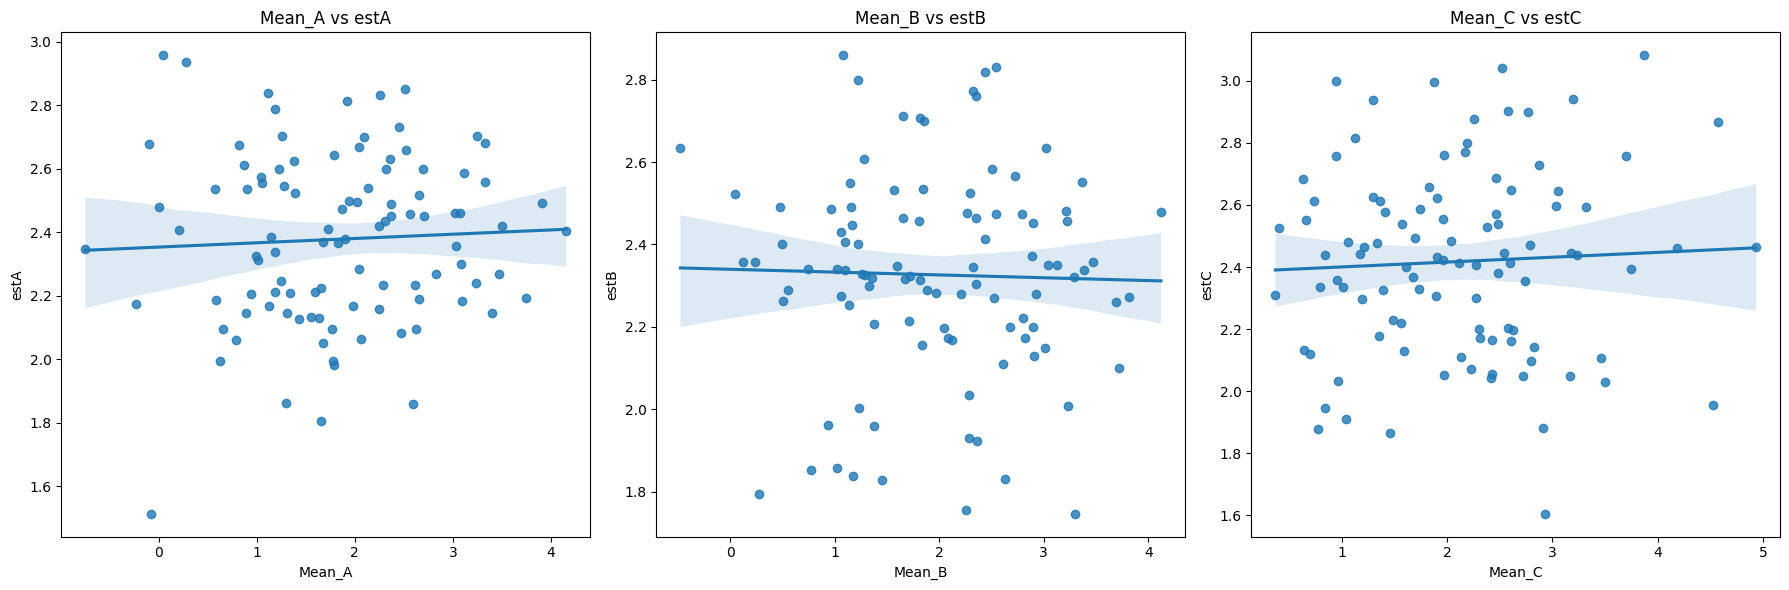

In [45]:
# Initialize the plot with 3 panes
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Mean_A vs estA
sns.regplot(data=values_df, x='Mean_A', y='estA', ax=axes[0])
axes[0].set_title('Mean_A vs estA')

# Plot Mean_B vs estB
sns.regplot(data=values_df, x='Mean_B', y='estB', ax=axes[1])
axes[1].set_title('Mean_B vs estB')

# Plot Mean_C vs estC
sns.regplot(data=values_df, x='Mean_C', y='estC', ax=axes[2])
axes[2].set_title('Mean_C vs estC')

# Adjust layout
plt.tight_layout()
plt.show()

In [46]:
values_df

,Subject,Mean_A,SD_A,Mean_B,SD_B,Mean_C,SD_C,estA,estB,estC
0,0,1.652188,1,2.884327,1,1.213692,1,1.807,2.372,2.463
1,1,0.278858,1,1.850798,1,1.121199,1,2.938,2.700,2.816
2,2,1.549638,1,0.048233,1,0.939182,1,2.134,2.523,2.757
3,3,0.816447,1,1.163934,1,1.292297,1,2.676,2.447,2.627
4,4,2.699832,1,1.225571,1,1.056907,1,2.452,2.401,2.481
...,...,...,...,...,...,...,...,...,...,...
95,95,0.987581,1,3.298346,1,1.608757,1,2.327,1.746,2.401
96,96,1.921544,1,0.936434,1,3.229688,1,2.813,1.962,2.439
97,97,2.367129,1,2.351954,1,1.586761,1,2.489,2.305,2.128
98,98,3.068271,1,3.022116,1,2.426059,1,2.460,2.634,2.054
